### S50 - ACTUALIZAR DATOS DEL HEADER ya Existentes en CONNEXA 

Parte de los forecast executión que están en estado 50 (Ya publicados OK), Genera los datos acumulados del registro excec y sube los archivos a connexa

In [ ]:
# Importar librerías estándar
import os
import shutil
import time
from datetime import datetime
from random import randint

# Importar librerías de terceros
import pandas as pd
import numpy as np
from dotenv import dotenv_values

# Importar funciones necesarias del módulo `funciones_forecast`
from funciones_forecast import (
    Open_Conn_Postgres,
    Close_Connection,
    get_execution_by_status,
    Open_Postgres_retry,
    mover_archivos_procesados,
    actualizar_site_ids,
    insertar_graficos_forecast,
    get_precios,
    get_execution_execute_by_status,
    update_execution,
    update_execution_execute,
    create_execution_execute_result,
    generar_mini_grafico,
    generar_grafico_base64
)

# Importar librerías adicionales necesarias
import ace_tools_open as tools

# Cargar configuraciones desde archivo `.env`
secrets = dotenv_values(".env")
folder = secrets["FOLDER_DATOS"]



In [5]:
fes = get_execution_execute_by_status(50)
tools.display_dataframe_to_user(name="Contenido de Archivos Markdown", dataframe=fes)

Contenido de Archivos Markdown


# EJECUTABLE PYTHON

In [ ]:

def insertar_graficos_forecast(algoritmo, name, id_proveedor):
        
    # Recuperar Historial de Ventas
    df_ventas = pd.read_csv(f'{folder}/{name}_Ventas.csv')
    df_ventas['Codigo_Articulo']= df_ventas['Codigo_Articulo'].astype(int)
    df_ventas['Sucursal']= df_ventas['Sucursal'].astype(int)
    df_ventas['Fecha']= pd.to_datetime(df_ventas['Fecha'])

    # Recuperando Forecast Calculado
    df_forecast = pd.read_csv(f'{folder}/{algoritmo}_Solicitudes_Compra.csv')
    df_forecast.fillna(0)   # Por si se filtró algún missing value
    print(f"-> Datos Recuperados del CACHE: {id_proveedor}, Label: {name}")
    
    # Agregar la nueva columna de gráficos en df_forecast Iterando sobre todo el DATAFRAME
    df_forecast["GRAFICO"] = df_forecast.apply(
        lambda row: generar_grafico_base64(df_ventas, row["Codigo_Articulo"], row["Sucursal"], row["Forecast"], row["Average"], row["ventas_last"], row["ventas_previous"], row["ventas_same_year"]) if not pd.isna(row["Codigo_Articulo"]) and not pd.isna(row["Sucursal"]) else None,
        axis=1
    )
    
    return df_forecast

#### S50 ACTUALIZAR SOLO CABECERAS

In [ ]:
elegido = '62_ARCOR_ALGO_05'
    
for index, row in fes[fes["name"] == elegido].iterrows():
    algoritmo = row["name"]
    name = algoritmo.split('_ALGO')[0]
    execution_id = row["forecast_execution_id"]
    id_proveedor = row["ext_supplier_code"]
    forecast_execution_execute_id = row["forecast_execution_execute_id"]
    supplier_id = row["supplier_id"]
    
    folderP = folder + '/procesado'

    print(f"Algoritmo: {algoritmo}  - Name: {name} exce_id: {forecast_execution_execute_id} id: Proveedor {id_proveedor}")
    print(f"supplier-id: {supplier_id} ----------------------------------------------------")

    try:
        # Leer forecast extendido
        df_forecast_ext = pd.read_csv(f'{folderP}/{algoritmo}_Pronostico_Extendido_Con_Graficos.csv')
        df_forecast_ext['Codigo_Articulo'] = df_forecast_ext['Codigo_Articulo'].astype(int)
        df_forecast_ext['Sucursal'] = df_forecast_ext['Sucursal'].astype(int)
        df_forecast_ext.fillna(0, inplace=True)
        print(f"-> Datos Recuperados del CACHE: {id_proveedor}, Label: {name}")
        print("❗Filas con site_id inválido:", df_forecast_ext['site_id'].isna().sum())
        print("❗Filas con product_id inválido:", df_forecast_ext['product_id'].isna().sum())

        # Hacer merge solo si no existen las columnas de precios y costos
        if 'I_PRECIO_VTA' not in df_forecast_ext.columns or 'I_COSTO_ESTADISTICO' not in df_forecast_ext.columns:
            print(f"❌ ERROR: Falta la columna requerida '{col}' procedemos a actualizar {id_proveedor}")
            precio = get_precios(id_proveedor)
            precio['C_ARTICULO'] = precio['C_ARTICULO'].astype(int)
            precio['C_SUCU_EMPR'] = precio['C_SUCU_EMPR'].astype(int)

            df_forecast_ext = df_forecast_ext.merge(
                precio,
                left_on=['Codigo_Articulo', 'Sucursal'],
                right_on=['C_ARTICULO', 'C_SUCU_EMPR'],
                how='left'
            )
        else:
            print(f"⚠️ El DataFrame ya contiene precios y costos. Merge evitado para {id_proveedor}")
        
        # Verificar columnas necesarias después del merge
        columnas_requeridas = ['I_PRECIO_VTA', 'I_COSTO_ESTADISTICO']
        for col in columnas_requeridas:
            if col not in df_forecast_ext.columns:
                print(f"❌ ERROR: Falta la columna requerida '{col}' en df_forecast_ext para el proveedor {id_proveedor}")
                df_forecast_ext.to_csv(f"{folder}/{algoritmo}_ERROR_MERGE.csv", index=False)
                raise ValueError(f"Column '{col}' missing in df_forecast_ext. No se puede continuar.")

        # Cálculo de métricas x Línea en miles
        df_forecast_ext['Forecast_VENTA'] = (df_forecast_ext['Forecast'] * df_forecast_ext['I_PRECIO_VTA'] / 1000).round(2)
        df_forecast_ext['Forecast_COSTO'] = (df_forecast_ext['Forecast'] * df_forecast_ext['I_COSTO_ESTADISTICO'] / 1000).round(2)
        df_forecast_ext['MARGEN'] = (df_forecast_ext['Forecast_VENTA'] - df_forecast_ext['Forecast_COSTO'])

        # Asegurar que los valores son del tipo float (nativo de Python)
        total_venta = float(round(df_forecast_ext['Forecast_VENTA'].sum() / 1000, 2))
        total_costo = float(round(df_forecast_ext['Forecast_COSTO'].sum() / 1000, 2))
        total_margen = float(round(df_forecast_ext['MARGEN'].sum() / 1000, 2))
        total_productos = df_forecast_ext['Codigo_Articulo'].nunique()
        total_unidades = float(round(df_forecast_ext['Forecast'].sum() , 0))

        # Mini gráfico
        mini_grafico = generar_mini_grafico(folderP, name)
        
        # SIMULAR VALORES
        days = randint(0,75) # Simulación de stock_days entre 0 y 75
            
        # Definición de condiciones
        # Condiciones
        condiciones = [
            days > 30,
            (days > 10) & (days <= 30),
            days <= 10
        ]

        # Valores (colores) asociados a las condiciones
        colores = ['green', 'yellow', 'red']

        # Agregar un valor predeterminado (debe ser del mismo tipo: str)
        semaforo = np.select(condiciones, colores, default='unknown').astype(str)

        # Actualizar en base de datos            
        update_execution_execute(
            forecast_execution_execute_id,
            supply_forecast_execution_status_id=50,
            monthly_sales_in_millions=total_venta,
            monthly_purchases_in_millions=total_costo,
            monthly_net_margin_in_millions=total_margen,
            graphic=mini_grafico,
            total_products=total_productos,
            total_units=total_unidades,
            otif = randint(70, 100),  # Simulación de OTIF entre 70 y 100
            sotck_days = days, # Simulación de stock_days entre 10 y 76              
            #sotck_days_colors = semaforo, # Simulación de semaforo
            maximum_backorder_days = randint(0,45) # Simulación de oc_delay entre 0 y 45
            
        )
        
        print(f"✅ Estado actualizado a 50 para {execution_id}")
        
        # # ✅ Morver Archivo a carpeta de Procesado ....
        # mover_archivos_procesados(algoritmo, folder)
        # print(f"✅ Archivo movido a Procesado: {algoritmo}")

    except Exception as e:
        import traceback
        traceback.print_exc()

Algoritmo: 62_ARCOR_ALGO_05  - Name: 62_ARCOR exce_id: a97250ed-3d31-4338-b493-659ebcb96691 id: Proveedor 62
supplier-id: f603814e-c2d8-49b2-8738-24f9cc0a7e89 ----------------------------------------------------
-> Datos Recuperados del CACHE: 62, Label: 62_ARCOR
❗Filas con site_id inválido: 0
❗Filas con product_id inválido: 0
⚠️ El DataFrame ya contiene precios y costos. Merge evitado para 62
✅ Estado actualizado a 50 para a85ef5dd-b12a-4a27-a4b5-80b78d10cdf7


In [18]:
print(semaforo)

yellow


## PARCHES y ARREGLO DE PROBLEMAS

In [ ]:
    # ARREGLAR PROBLEMAS
df_sin_duplicados = df_forecast_ext.drop_duplicates(subset=['Codigo_Articulo', 'Sucursal'], keep='first')
file_path = f"{folder}/{algoritmo}_Pronostico_Extendido_Con_Graficos.csv"
df_sin_duplicados.to_csv(file_path, index=False)

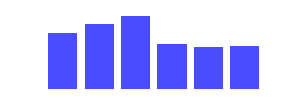

In [14]:
import matplotlib.pyplot as plt
import base64
from io import BytesIO
from IPython.display import display, Image

# Función para decodificar y mostrar una imagen en Jupyter Notebook
    
img_data = base64.b64decode(mini_grafico)
buffer = BytesIO(img_data)

# Mostrar la imagen en Jupyter Notebook
display(Image(buffer.getvalue()))


In [7]:
# Actualizar en base de datos            
update_execution_execute(
    forecast_execution_execute_id,
    supply_forecast_execution_status_id=50,
    monthly_sales_in_millions=total_venta,
    monthly_purchases_in_millions=total_costo,
    monthly_net_margin_in_millions=total_margen,
    graphic=mini_grafico,
    total_products=total_productos,
    total_units=total_unidades,
    otif = randint(70, 100),  # Simulación de OTIF entre 70 y 100
    sotck_days = randint(10,76), # Simulación de stock_days entre 10 y 76
    sotck_days_colors ='green', # Simulación de semaforo
    maximum_backorder_days = randint(0,45) # Simulación de oc_delay entre 0 y 45
    
)

{'id': '01307697-fcd2-4bcd-af58-474f90cea46d',
 'end_execution': datetime.datetime(2025, 3, 17, 19, 1, 53, 784314),
 'last_execution': True,
 'start_execution': datetime.datetime(2025, 3, 17, 19, 1, 53, 784314),
 'timestamp': datetime.datetime(2025, 3, 17, 19, 1, 53, 784314),
 'supply_forecast_execution_id': '6fd161ef-000d-4e0e-aef0-249eb2f3db5b',
 'supply_forecast_execution_schedule_id': 'dc176612-7b08-46a9-afeb-a312d844717e',
 'ext_supplier_code': '25',
 'graphic': 'iVBORw0KGgoAAAANSUhEUgAAASwAAABkCAYAAAA8AQ3AAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAZZJREFUeJzt2sERgkAQAEGxTI9oCXBNwFJe4EB3Atznppa6XWZmHgABz7MPALCXYAEZggVkCBaQIVhAhmABGYIFZAgWkCFYQIZgARmCBWQIFpAhWECGYAEZggVkvM4+wBWt6/Hf3LbjvwlHM2EBGYIFZAgWkCFYQIZgARmCBWQIFpAhWECGYAEZ+U13W+VwHyYsICM/YfGbKZSrMGEBGYIFZAgWkCFYQIZgARmCBWQIFpBhDwvsqmWYsIAMwQIyBAvIECwgQ7CADK+E8Ie8Wn4mWNziMlYuJN/5JQQyBAvIECwgQ7CADMECMgQLyBAsIEOwgAzBAjIEC8gQLCBDsIAMwQIyBAvIECwgQ7C